In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import interp1d

def load_pkl(name, data_dir="simulation_data"):
    with open(os.path.join(data_dir, name), "rb") as f:
        return pickle.load(f)

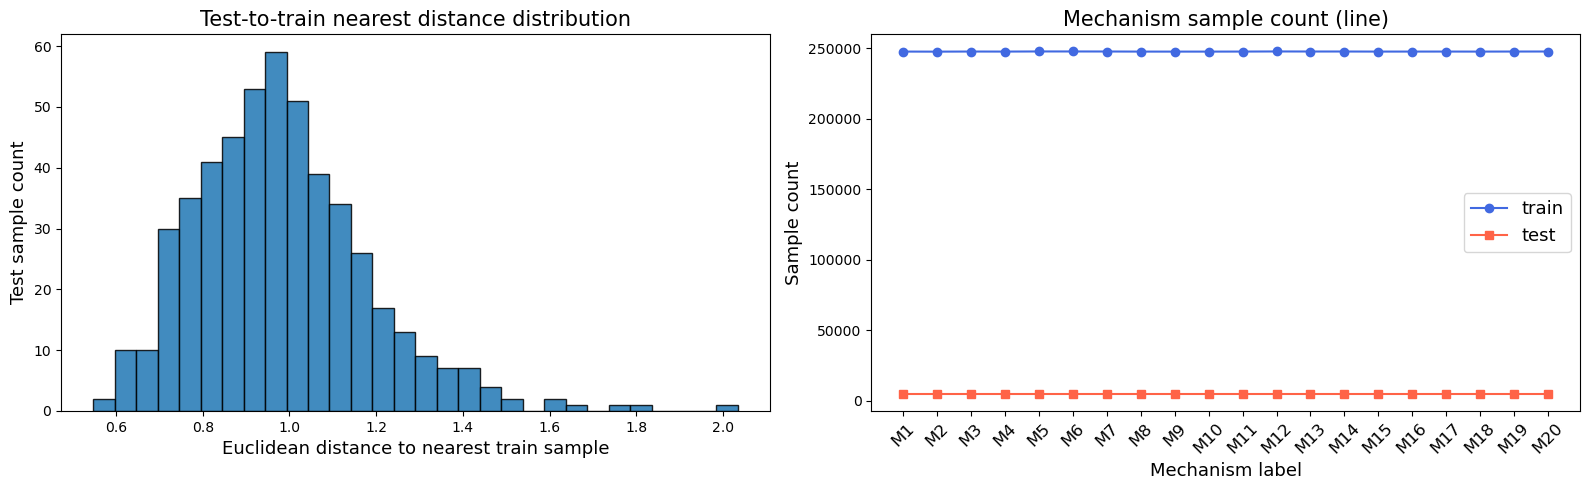

In [2]:
def plot_coverage_and_mechanism_distribution(data_dir="simulation_data"):
    x2_train = load_pkl("x2_train_M1_M20.pkl", data_dir)
    x2_test = load_pkl("x2_test_M1_M20.pkl", data_dir)
    y_train = load_pkl("y_train_M1_M20.pkl", data_dir)
    y_test = load_pkl("y_test_M1_M20.pkl", data_dir)

    n_train = min(1000, x2_train.shape[0])
    n_test = min(500, x2_test.shape[0])
    X_train = x2_train[:n_train].reshape(n_train, -1)
    X_test_interp = []
    for i in range(n_test):
        arr = x2_test[i]
        arr_interp = []
        for j in range(12):
            f = interp1d(np.linspace(0, 1, 7), arr[:, j], kind='linear', fill_value='extrapolate')
            arr_interp.append(f(np.linspace(0, 1, 21)))
        arr_interp = np.stack(arr_interp, axis=1)
        X_test_interp.append(arr_interp.reshape(-1))
    X_test_interp = np.array(X_test_interp)
    nn = NearestNeighbors(n_neighbors=1).fit(X_train)
    dists, _ = nn.kneighbors(X_test_interp)
    dists = dists.flatten()

    if y_train.ndim == 2 and y_train.shape[1] > 1:
        mech_train = np.argmax(y_train, axis=1)
    else:
        mech_train = y_train.flatten()
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        mech_test = np.argmax(y_test, axis=1)
    else:
        mech_test = y_test.flatten()
    labels = [f"M{i+1}" for i in range(20)]
    train_counts = np.bincount(mech_train, minlength=20)
    test_counts = np.bincount(mech_test, minlength=20)

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].hist(dists, bins=30, alpha=0.85, edgecolor='k')
    axs[0].set_xlabel('Euclidean distance to nearest train sample', fontsize=13)
    axs[0].set_ylabel('Test sample count', fontsize=13)
    axs[0].set_title('Test-to-train nearest distance distribution', fontsize=15)

    x = np.arange(20)
    axs[1].plot(x, train_counts, marker='o', label='train', color='royalblue')
    axs[1].plot(x, test_counts, marker='s', label='test', color='tomato')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels, rotation=45, fontsize=12)
    axs[1].set_xlabel('Mechanism label', fontsize=13)
    axs[1].set_ylabel('Sample count', fontsize=13)
    axs[1].set_title('Mechanism sample count (line)', fontsize=15)
    axs[1].legend(fontsize=13)

    plt.tight_layout()
    plt.show()

plot_coverage_and_mechanism_distribution("simulation_data")